In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
scv.settings.verbosity = 0



import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('/data/nelkazwi/code/UniTVelo-ATAC/crak-velo')
from supplement.fitting_genes_regions import compute_alpha_atac, region_unspliced_kinetics
from pl.pl import gene_weights_plots, region_kinetic_plot,scatter_plot
from supplement.eval_utils import KNN_eval, evaluate

In [4]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [27]:
path_result = '/data/nelkazwi/code/UniTVelo-ATAC/notebooks/data/HSPC_dataset/'
adata = sc.read(path_result+"adata_rna_fit.h5ad")
adata_atac = sc.read(path_result+"adata_atac_fit.h5ad")
B = np.loadtxt(path_result+'B.txt', delimiter=',')

adata_unv = sc.read(path_result+'adata_unitvelo.h5ad')

key_celltype = 'celltype'

adata_mv = sc.read_h5ad(path_result+"adata_multivelo.h5ad")
key_celltype_mv = 'leiden'


computing velocity graph (using 1/112 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:00:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_HSPC_CRAK-Velo.png


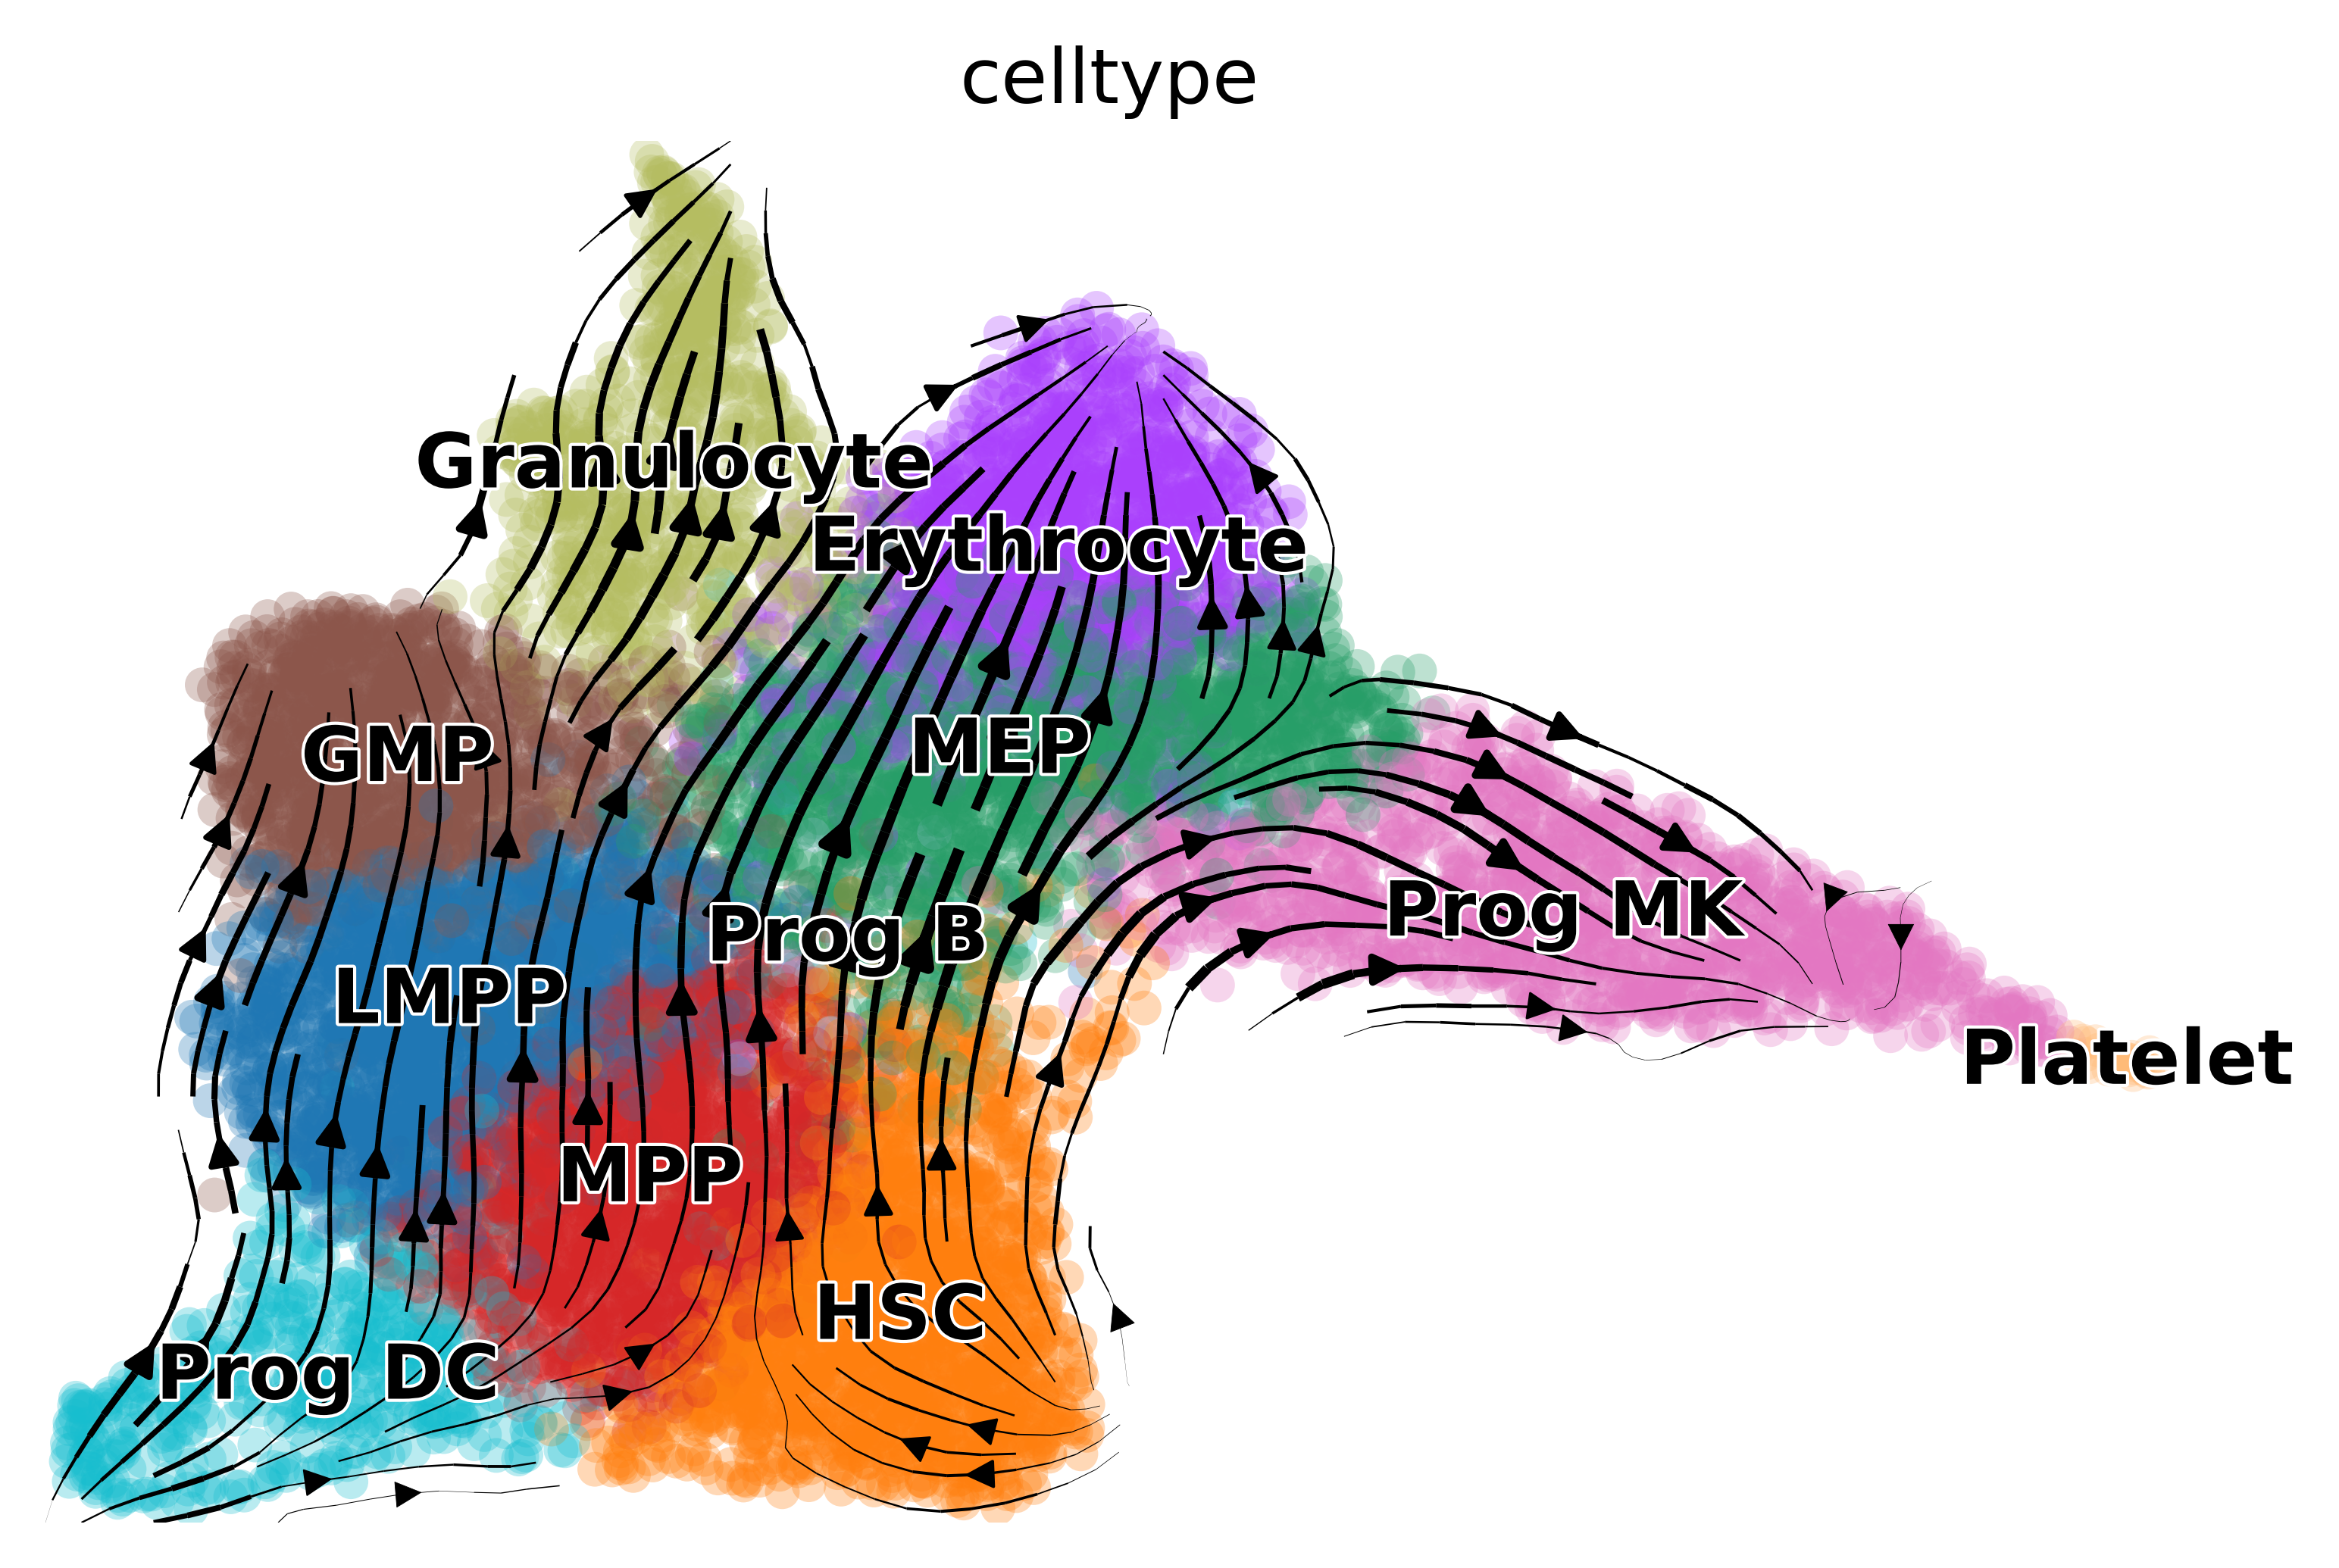

In [6]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=['celltype'], dpi=300,
                                  color_map='gnuplot')

computing velocity graph (using 1/112 cores)


  0%|          | 0/11605 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


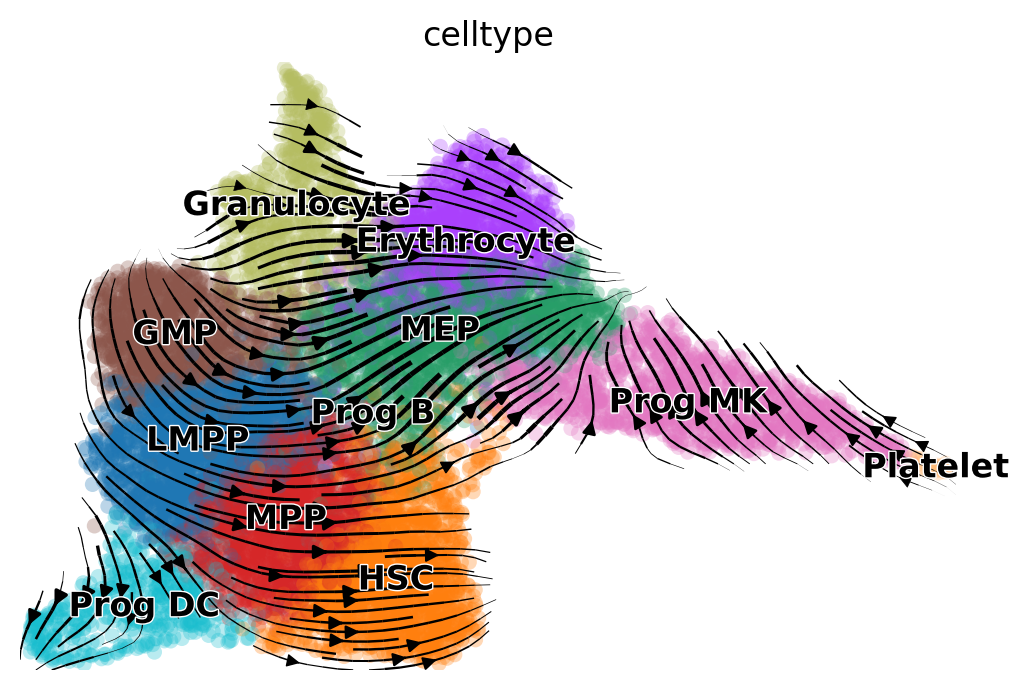

In [7]:
scv.tl.velocity_graph(adata_unv)
scv.pl.velocity_embedding_stream(adata_unv, color=['celltype'], dpi=100,
                                  color_map='gnuplot')

In [9]:
alpha_atac, adata = compute_alpha_atac(adata, adata_atac, B)


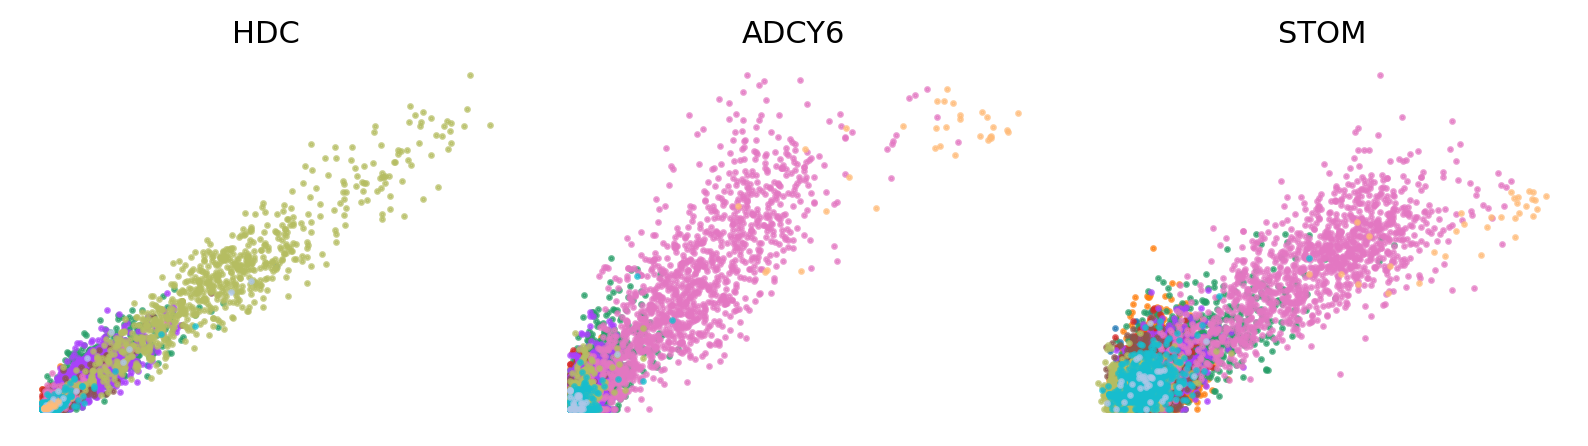

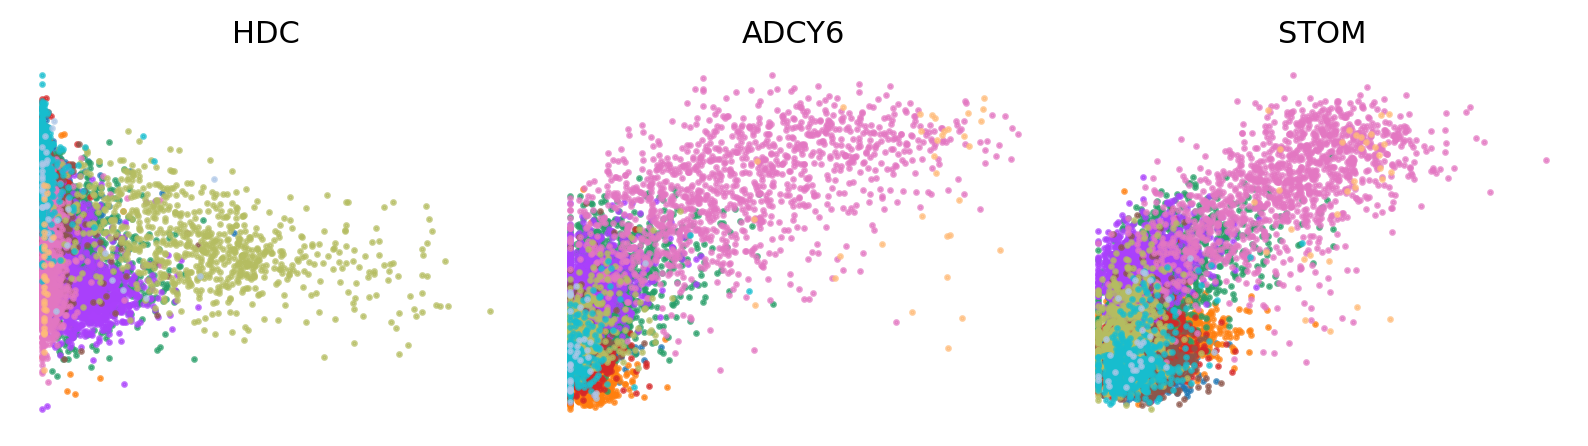

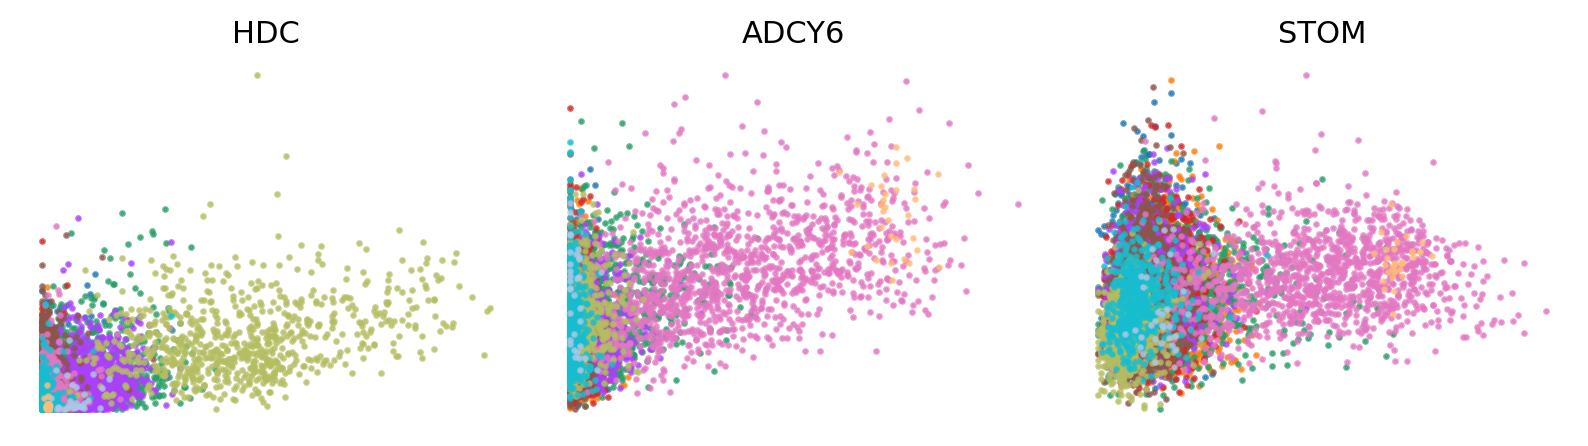

In [10]:
gene_list = ['HDC', 'ADCY6', 'STOM']


scatter_plot(adata, gene_list, color_by=key_celltype, by='us',  axis_on=False, frame_on=False)



scatter_plot(adata, gene_list, color_by=key_celltype, by='cu',  axis_on=False, frame_on=False)


scatter_plot(adata_mv, genes=gene_list, color_by=key_celltype_mv, by='cu', axis_on=False, frame_on=False)


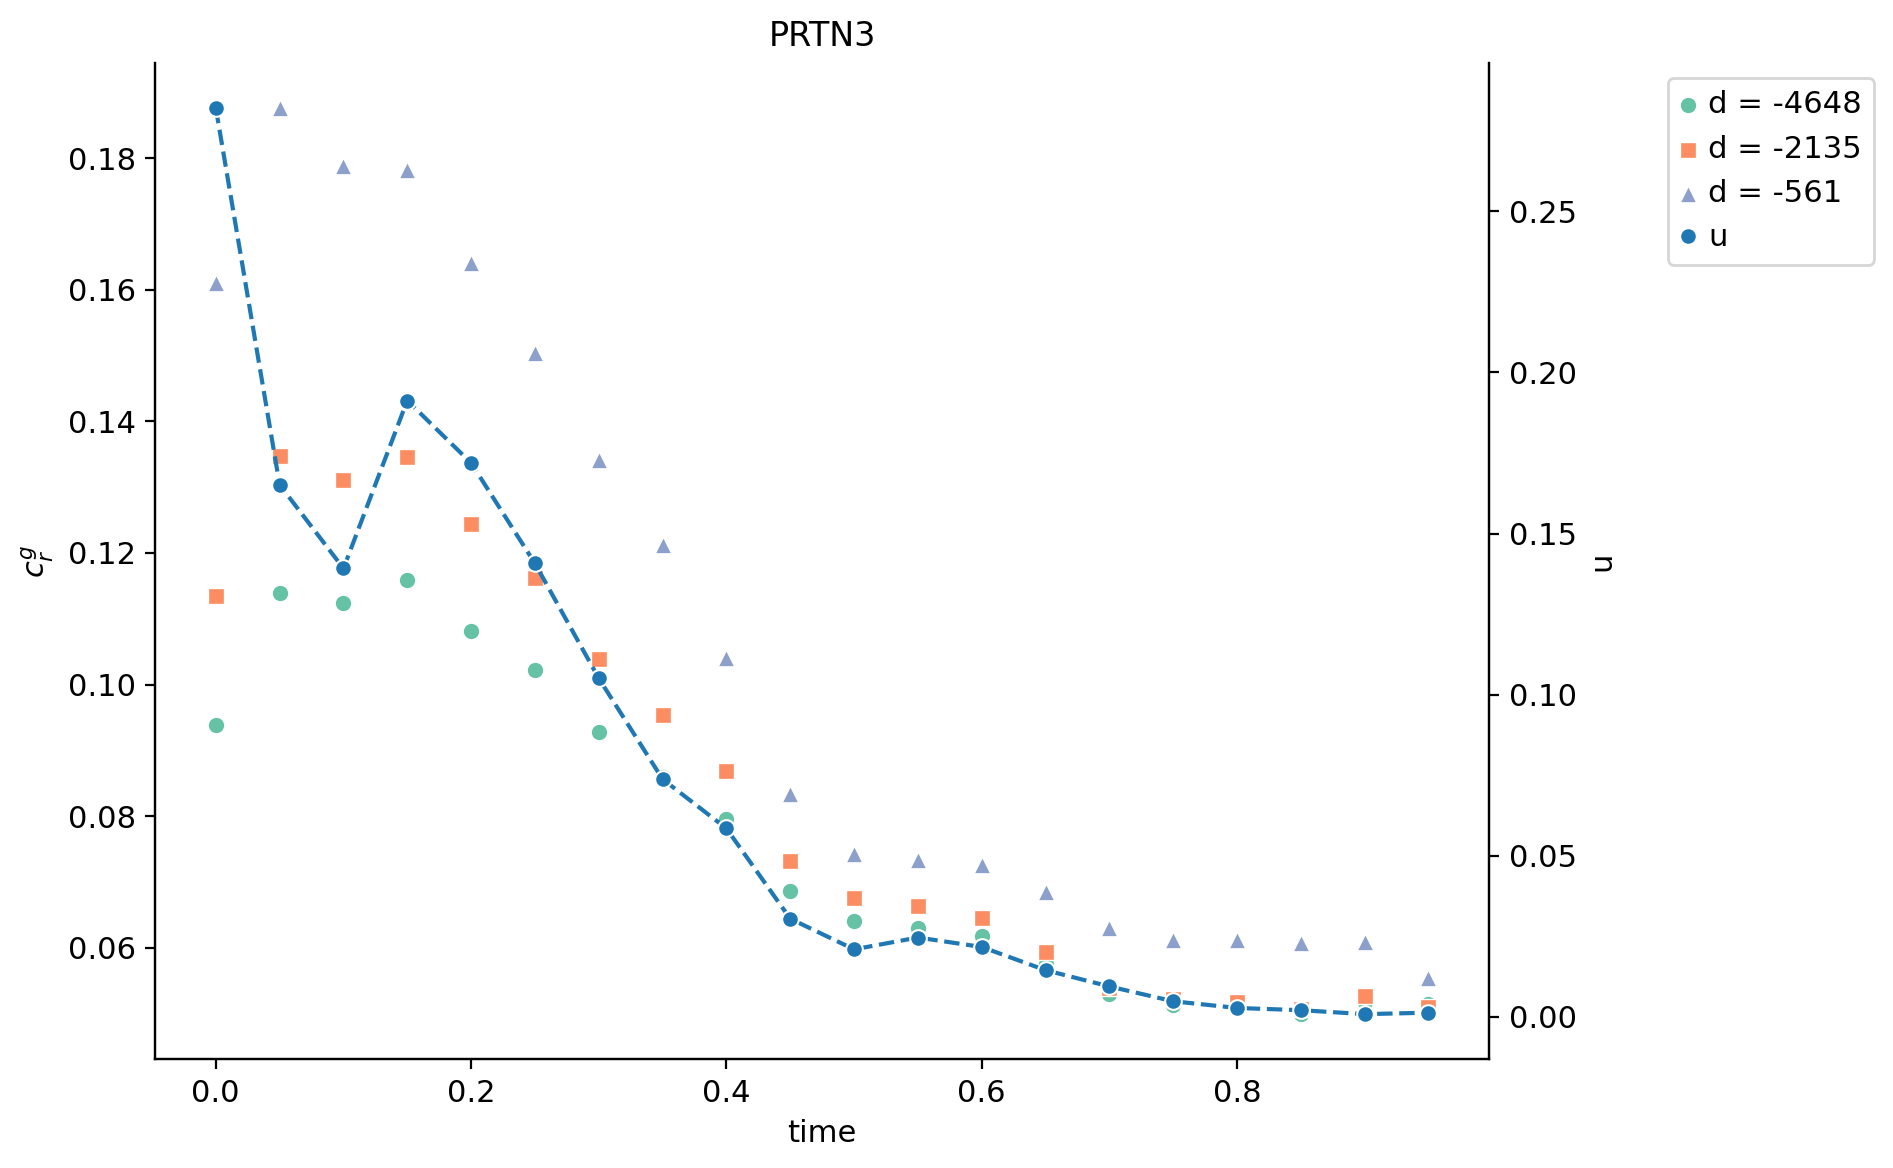

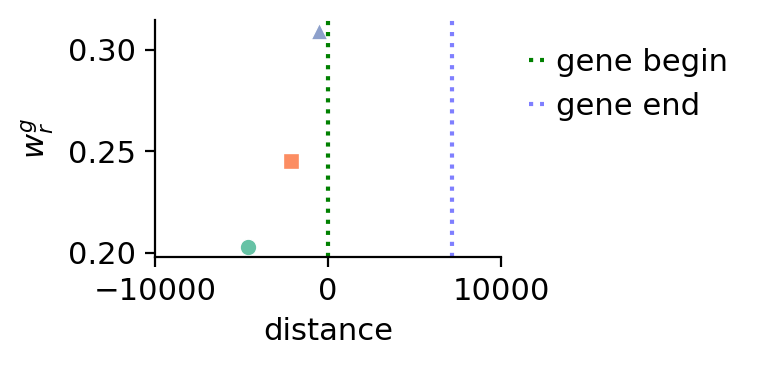

In [11]:
gene_name = 'PRTN3'
time, c, u_avg = region_unspliced_kinetics(adata, adata_atac, B, gene_name, interval = 0.05)
region_kinetic_plot(adata,adata_atac,gene_name, time, c, u_avg,B)

In [12]:
key_celltype = 'celltype'
key_celltype_mv = 'leiden'

In [13]:
acc, acc_mv, acc_su = KNN_eval (adata, adata_mv, key_celltype, key_celltype_mv)

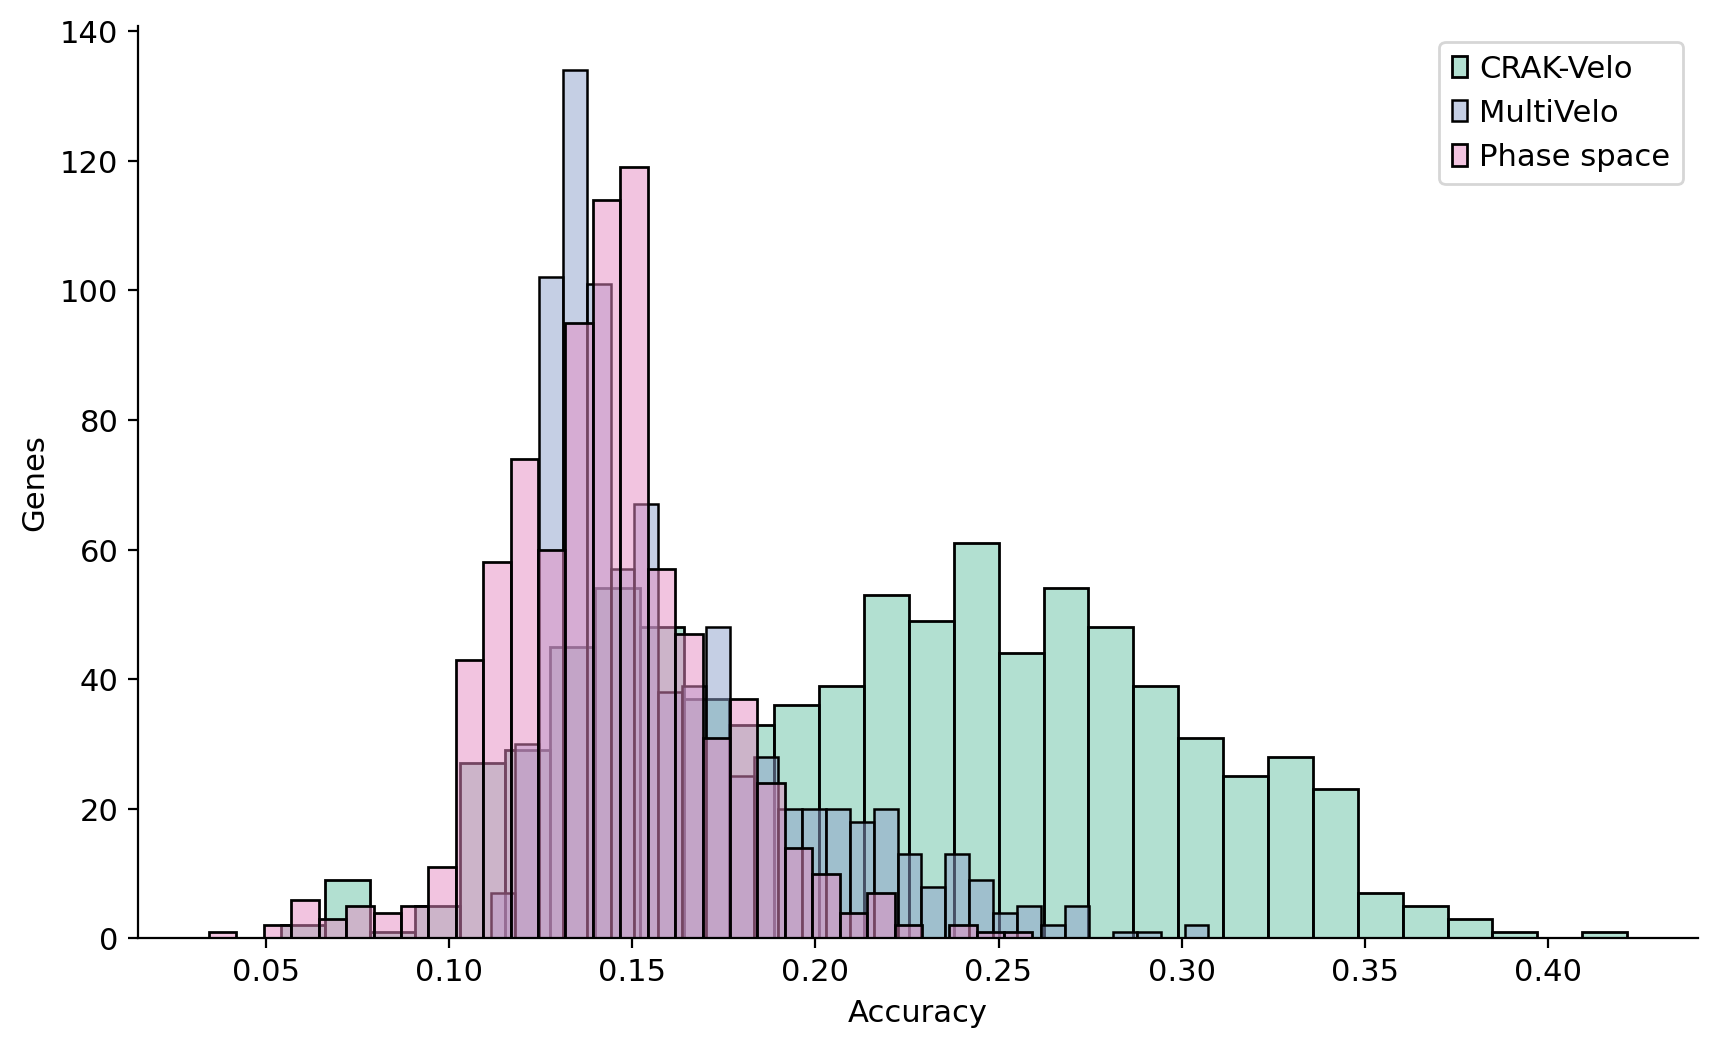

In [15]:
bins=30
alpha=0.5

colors = plt.get_cmap('Set2').colors
labels = ['CRAK-Velo', 'MultiVelo', 'Phase space']#
plt.figure(figsize=(10, 6))
n = 0
sns.histplot(acc, bins=bins, color=colors[n], label=labels[0], alpha=alpha, kde=False)
sns.histplot(acc_mv, bins=bins, color=colors[n+2], label=labels[1], alpha=alpha, kde=False)
plot = sns.histplot(acc_su, bins=bins, color=colors[n+3], label=labels[2], alpha=alpha, kde=False)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plt.ylabel("Genes")
plt.xlabel("Accuracy")
plt.legend()




In [16]:
cluster_edges = [
    ('HSC', 'MPP'), 
    ('MPP', 'LMPP'),
    ('LMPP', 'GMP'),
    ('GMP', 'Granulocyte'),
    ( 'MEP', 'Erythrocyte'),
    ('Prog MK', 'Platelet'),
    ]

trans = ['HSC -> MPP',
         'MPP -> LMPP',
        'LMPP -> GMP',
        'GMP -> Granulocyte',
        'MEP -> Erythrocyte',
        'Prog MK -> Platelet'
         ]

exp_metrics = {}

In [8]:
import sys
import importlib



sys.modules.pop('supplement.eval_utils', None)

# Reload the module
importlib.import_module('supplement.eval_utils')



from supplement.eval_utils import evaluate

%load_ext autoreload
%autoreload 2

In [17]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = evaluate(adata_velo, cluster_edges, key_celltype, 'velocity', 'X_umap', verbose=False)


CBDir ={}
for edge , t in zip(cluster_edges,trans):
 CBDir[t] = np.array(exp_metrics["model_dyn"]['Cross-Boundary Direction Correctness (A->B)'][(edge)]).mean()

computing neighbors


2024-09-11 20:34:39.866901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 20:34:40.007761: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 20:34:40.011312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-11 20:34:40.011325: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

    finished (0:00:31) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [18]:
scv.pp.neighbors(adata_unv)
adata_velo = adata_unv[:, adata_unv.var.loc[adata_unv.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = evaluate(adata_velo, cluster_edges, key_celltype, 'velocity', 'X_umap', verbose=False)


CBDir_unv ={}
for edge, t in zip(cluster_edges,trans):
 CBDir_unv[t] = np.array(exp_metrics["model_dyn"]['Cross-Boundary Direction Correctness (A->B)'][(edge)]).mean()

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [19]:
scv.pp.neighbors(adata_mv)
adata_velo = adata_mv[:, adata_mv.var.loc[adata_mv.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = evaluate(adata_velo, cluster_edges, key_celltype_mv,'velo_s_norm', verbose=False)


CBDir_mv ={}
for edge , t in zip(cluster_edges,trans):
 CBDir_mv[t] = np.array(exp_metrics["model_dyn"]['Cross-Boundary Direction Correctness (A->B)'][(edge)]).mean()

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [20]:
methods = ['CRAK-Velo', 'UniTVelo', 'MultiVelo']#

CBDirs = {}
CBDirs[methods[0]] = CBDir
CBDirs[methods[1]] = CBDir_unv
CBDirs[methods[2]] = CBDir_mv


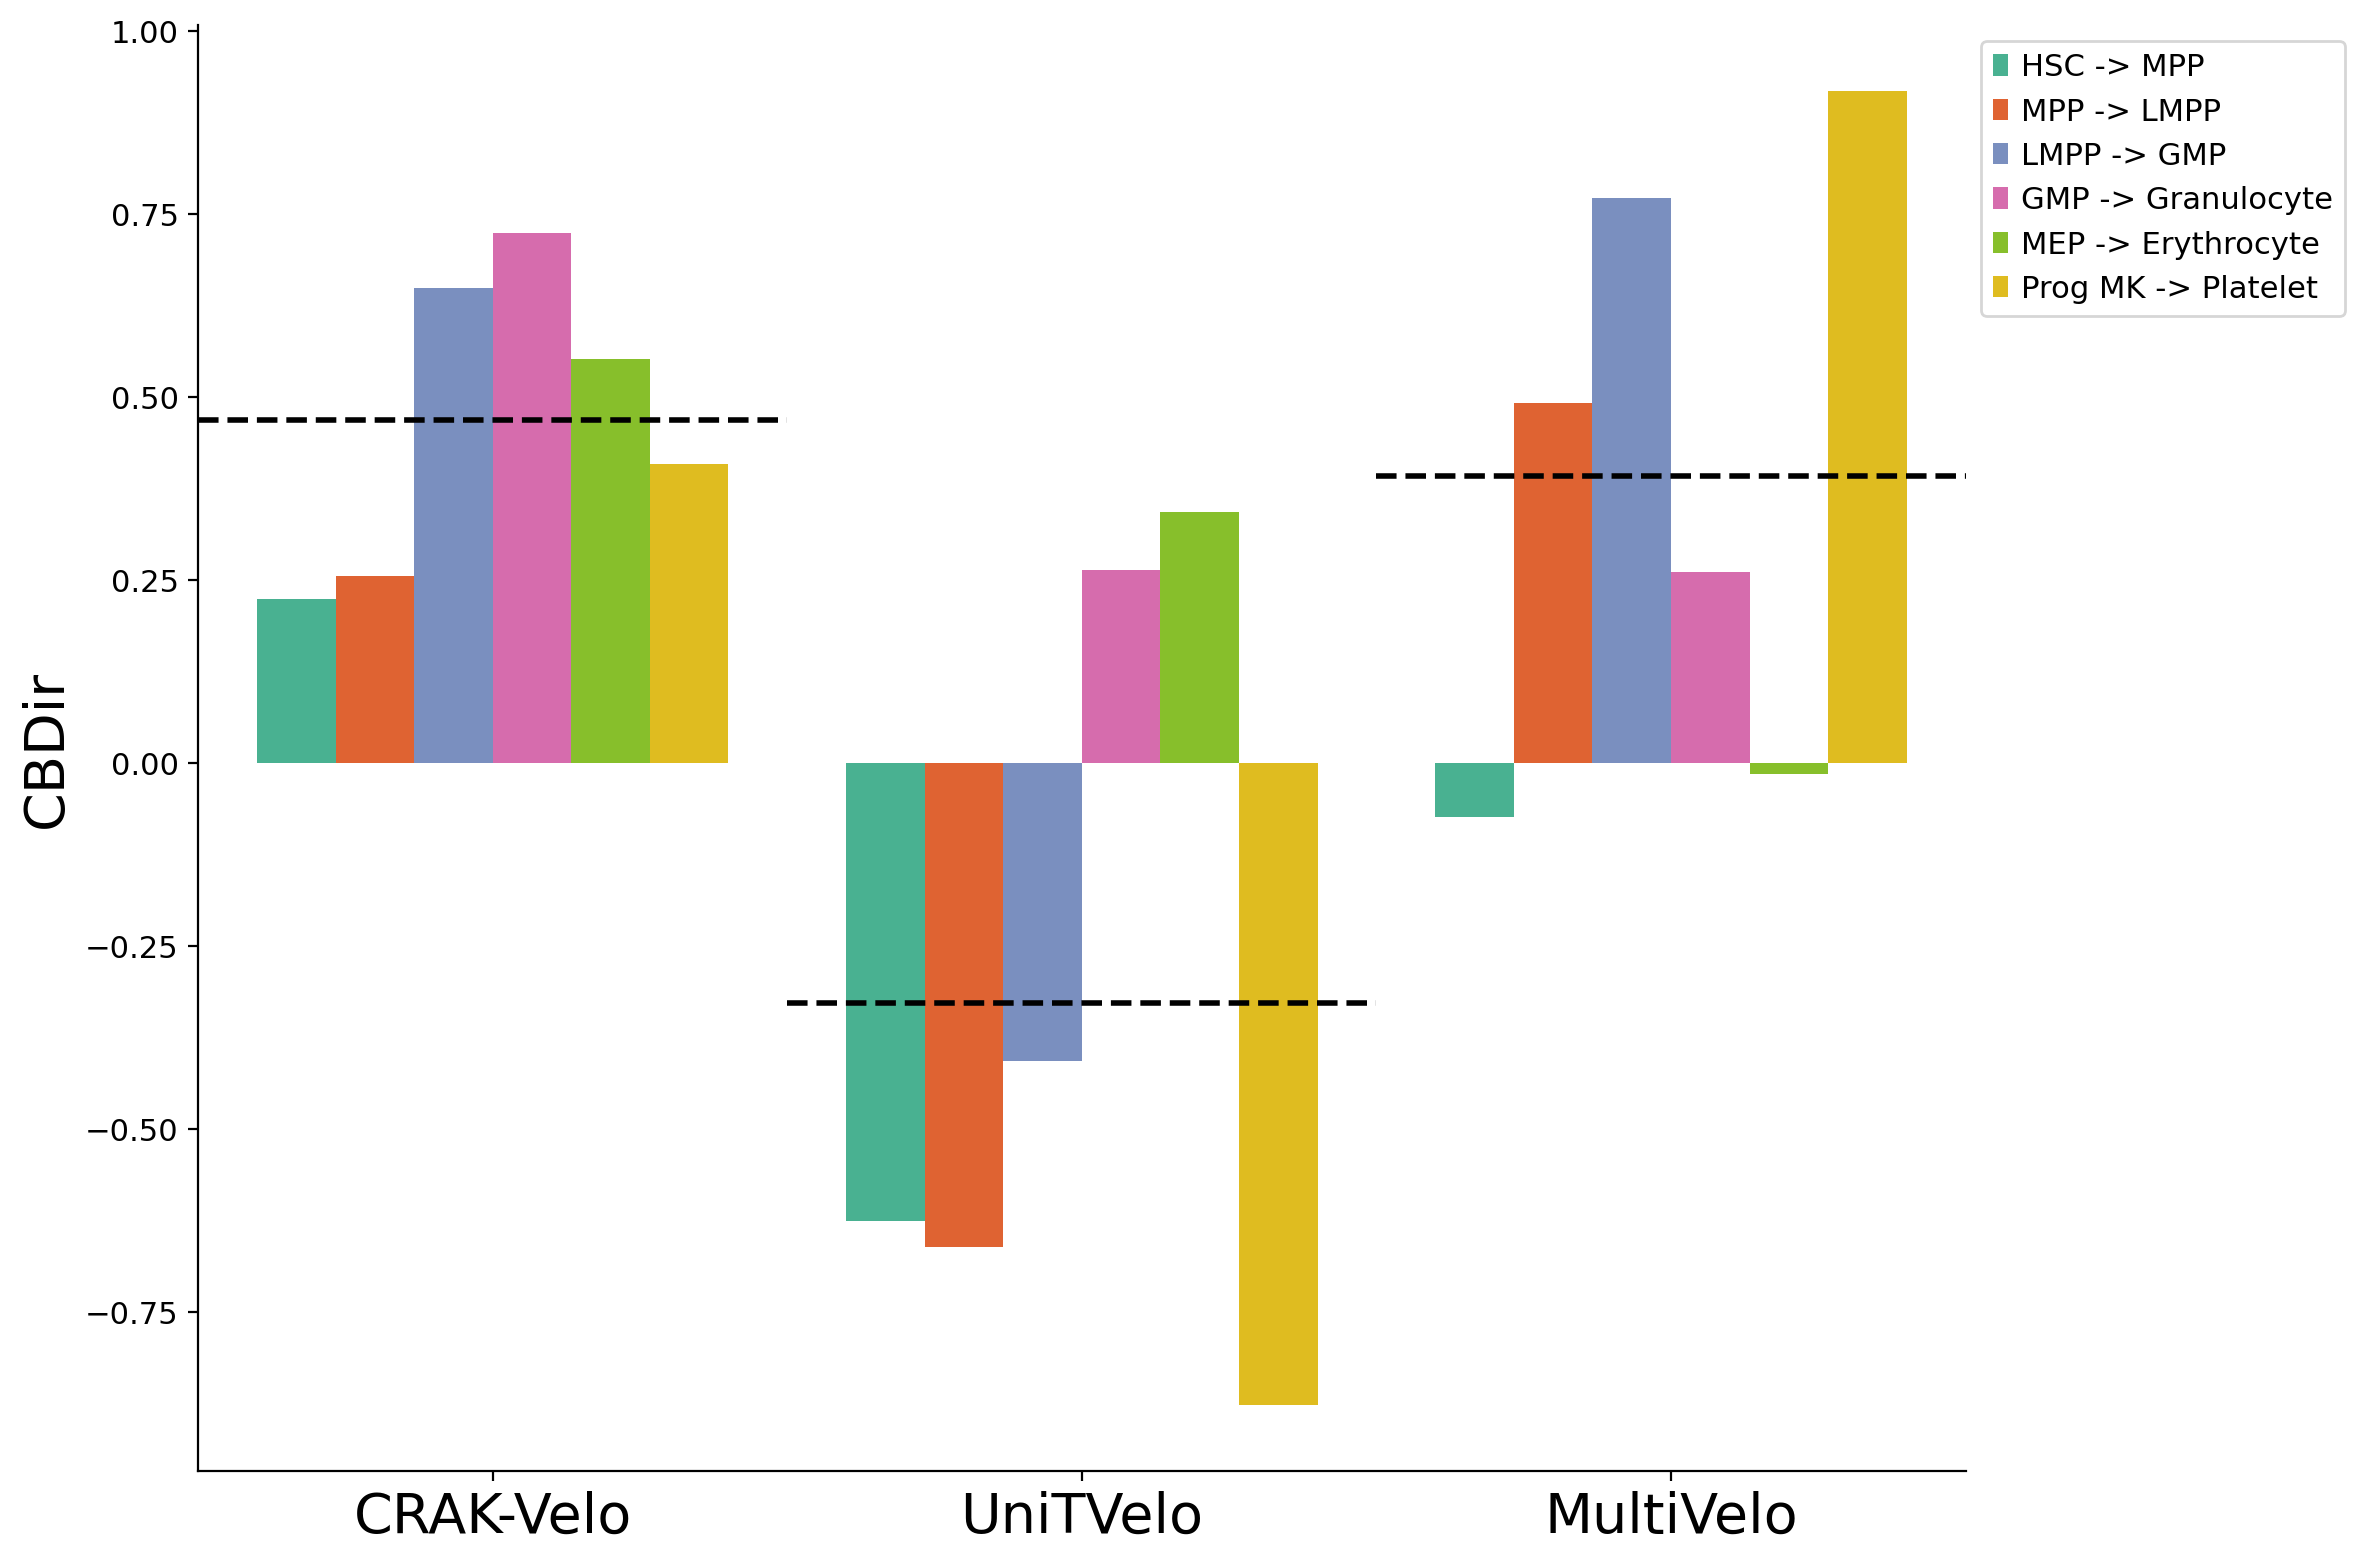

In [25]:
colors = ['#386641', '#6a994e', '#a7c957', '#f2e8cf', '#bc4749', '#7d8c2f', '#c1d3b5']
import matplotlib.colors as mcolors


data = CBDirs
df = pd.DataFrame(data).T.reset_index()
df.columns = ['Method'] + list(df.columns[1:])
def adjust_saturation(palette, factor=1.5):
    """Increase the saturation of a color palette."""
    adjusted_palette = []
    for color in palette:
        # Convert color to HSV (Hue, Saturation, Value)
        rgb = mcolors.to_rgba(color)[:3]
        hsv = mcolors.rgb_to_hsv(rgb)
        hsv[1] = min(hsv[1] * factor, 1)  # Increase saturation but keep it in [0, 1]
        rgb = mcolors.hsv_to_rgb(hsv)
        adjusted_palette.append(mcolors.to_hex(rgb))
    return adjusted_palette

# Use the Set2 color palette
palette = sns.color_palette('Set2')

# Increase the saturation of the palette
palette = adjust_saturation(palette, factor=1.5)


# Melt the DataFrame to long format suitable for Seaborn
df_melted = df.melt(id_vars='Method', var_name='Metric', value_name='Value')

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 8))
#sns.set_palette(colors)  # Set the color palette

# Plot with Seaborn
bar_plot = sns.barplot(data=df_melted, x='Method', y='Value', hue='Metric', palette=palette)

# Adjusting legend position
bar_plot.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adding labels and title
plt.xlabel('', fontsize=14) 
plt.ylabel('CBDir', fontsize=20)
plt.xticks(fontsize=20)

bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

means = df_melted.groupby('Method')['Value'].mean()

# Add a black dashed line at the mean value for each method
for i, method in enumerate(df['Method']):
    plt.axhline(y=means[method], color='black', linestyle='--', linewidth=2, 
                xmin=i/(len(df['Method'])), xmax=(i+1)/(len(df['Method'])))

plt.tight_layout() 





plt.show()




In [23]:
data = CBDir
values = data.values()
total_sum = sum(values)
total_sum / len(values)

0.4686286590214441

In [24]:
data = CBDir_mv
values = data.values()
total_sum = sum(values)
total_sum / len(values)

0.3918997000086059